In [1]:
%matplotlib inline
from __future__ import division
import serial
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
import pandas as pd
import xlsxwriter
import math
import collections

pylab.rcParams['figure.figsize'] = (10.0, 10.0)

/Users/legion/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
LEDDAR_FREQ = 50

In [3]:
def rolling_mean(array, points):
    cumsums = np.cumsum(np.insert(array, 0, 0))
    return (cumsums[points:] - cumsums[:-points]) / points

In [4]:
distances = list()
pwms = list()
with open("/Users/legion/Dropbox/Chomp/motor controller stuff/chump_speedtest_data.txt") as fh:
    for line in fh:
        fields = line.rstrip().split("\t")
        distance, pwm = int(fields[0]), float(fields[1])
        distances.append(distance)
        pwm -= 1520/20000
        pwms.append(pwm)

distances = np.array(distances)
pwms = np.array(pwms)

In [5]:
fdas = list()
step = 1
for i in range(4*step, len(distances) - 4*step):
    fda = (1/280*distances[i-step*4] - 4/105*distances[i-step*3] + 1/5*distances[i-step*2] - 4/5*distances[i-step] + 
           4/5*distances[i+step] - 1/5*distances[i+2*step] + 4/105*distances[i+3*step] - 1/280*distances[i+4*step])
    fdas.append(fda * LEDDAR_FREQ)

In [19]:
pavel_smooth_diffs = list()
step = 1
coeffs = np.array([1, 13, 77, 273, 637, 1001, 1001, 429, -429, -1001, -1001, -637, -273, -77, -13, -1])
for i in range(len(distances) - 16):
    smooth_diff = (distances[i:i+16][::-1] * coeffs).sum() / (16384 * 0.02)
    pavel_smooth_diffs.append(smooth_diff)

In [32]:
pavel_smooth_diffs2 = list()
step = 1
coeffs = np.array([322, 217, 110, 35, -42, -87, -134, -149, -166, -151, -138, -93, -50, 25, 98, 203])
for i in range(len(distances) - 16):
    smooth_diff = (distances[i:i+16][::-1] * coeffs).sum() / (2856 * 0.02)
    pavel_smooth_diffs2.append(smooth_diff)

In [14]:
distances[300:315]

array([1110, 1109, 1109, 1108, 1108, 1108, 1108, 1107, 1107, 1107, 1106,
       1106, 1106, 1106, 1105])

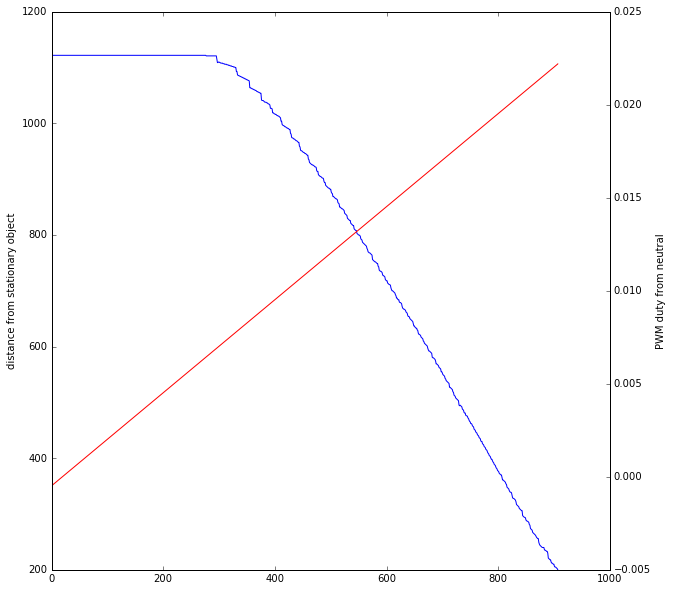

In [5]:
plt.plot(distances)
plt.ylabel("distance from stationary object")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(pwms, color="red")
plt.ylabel("PWM duty from neutral")

(-500.0, 100.0)

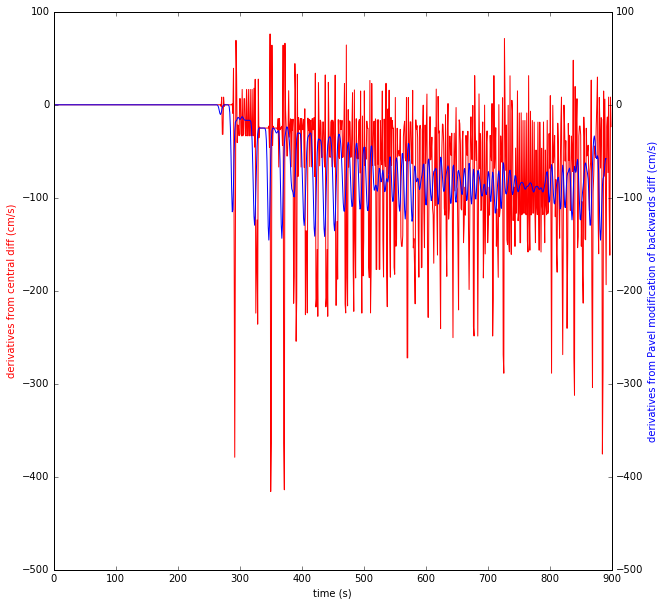

In [29]:
plt.plot(fdas, color="red")
plt.xlabel("time (s)")
plt.ylabel("derivatives from central diff (cm/s)", color="red")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(pavel_smooth_diffs)
plt.ylabel("derivatives from Pavel modification of backwards diff (cm/s)", color="blue")
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin, ymax)

(-200.0, 50.0)

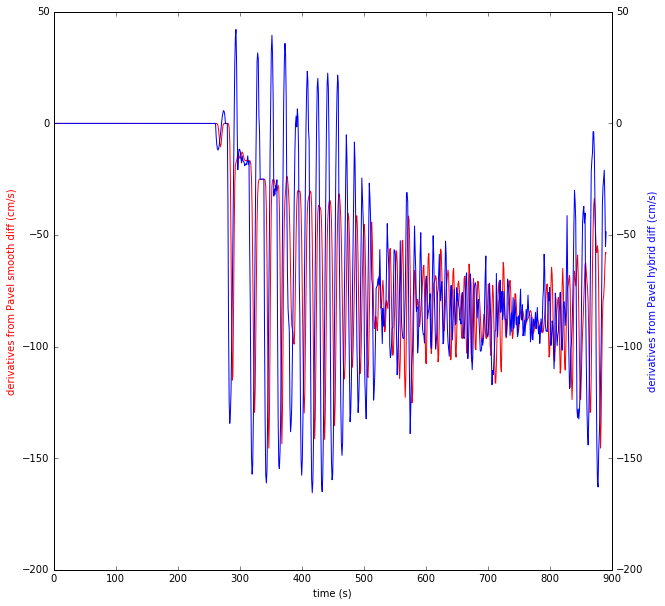

In [36]:
plt.plot(pavel_smooth_diffs, color="red")
plt.xlabel("time (s)")
plt.ylabel("derivatives from Pavel smooth diff (cm/s)", color="red")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(pavel_smooth_diffs2)
plt.ylabel("derivatives from Pavel hybrid diff (cm/s)", color="blue")
ymin1, ymax1 = ax1.get_ylim()
ymin2, ymax2 = ax2.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

In [8]:
def polyfit_derivative(data, num_points):
    poly_derivatives = list()
    for i in range(len(data) - num_points):
        x = sum(range(num_points)) / num_points
        polyfit = np.polyfit(range(num_points), data[i:i + num_points], 2)
        first_derivative = 2 * polyfit[0] * x + polyfit[1]
        poly_derivatives.append(first_derivative * LEDDAR_FREQ)
#         print first_derivative
    return np.array(poly_derivatives)

NameError: name 'pavel_smooth_diffs' is not defined

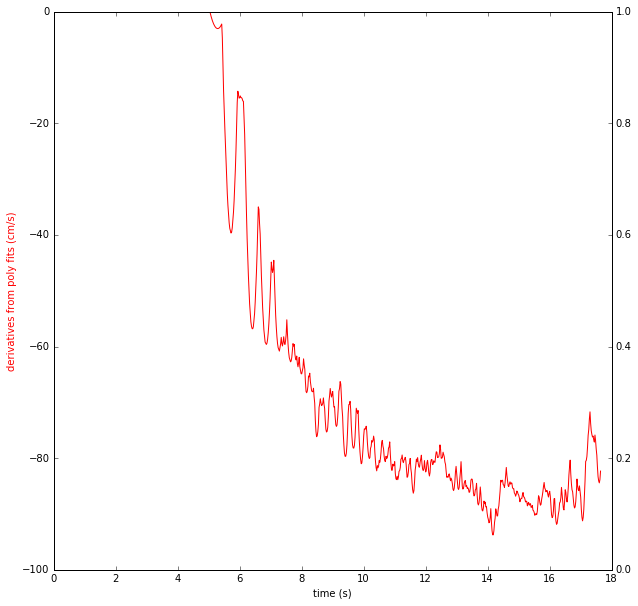

In [9]:
poly_derivatives = polyfit_derivative(distances, 25)
plt.plot(np.array(range(len(poly_derivatives))) / LEDDAR_FREQ, poly_derivatives, color="red")
plt.xlabel("time (s)")
plt.ylabel("derivatives from poly fits (cm/s)", color="red")
ax1 = plt.gca()
ax2 = ax1.twinx()
x = np.array(range(len(pavel_smooth_diffs))) / LEDDAR_FREQ
ax2.plot(x, pavel_smooth_diffs, linewidth=0.5)
y = rolling_mean(pavel_smooth_diffs, 25)
x = np.arange(len(y)) / LEDDAR_FREQ
ax2.plot(x, y, color="green")
plt.ylabel("finite difference approximations (cm/s)", color="blue")
ymin1, ymax1 = ax1.get_ylim()
ymin2, ymax2 = ax2.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(10, ymax1, ymax2)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

(0, 0.024999999999999998)

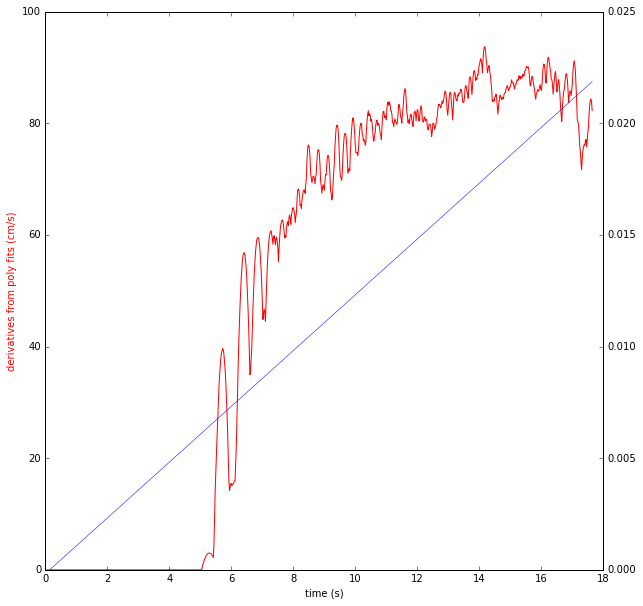

In [13]:
plt.plot(np.arange(len(poly_derivatives)) / LEDDAR_FREQ, -1 * poly_derivatives, color="red")
plt.xlabel("time (s)")
plt.ylabel("derivatives from poly fits (cm/s)", color="red")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(np.array(range(len(poly_derivatives))) / LEDDAR_FREQ, pwms[12:-13], linewidth=0.5)
ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax)

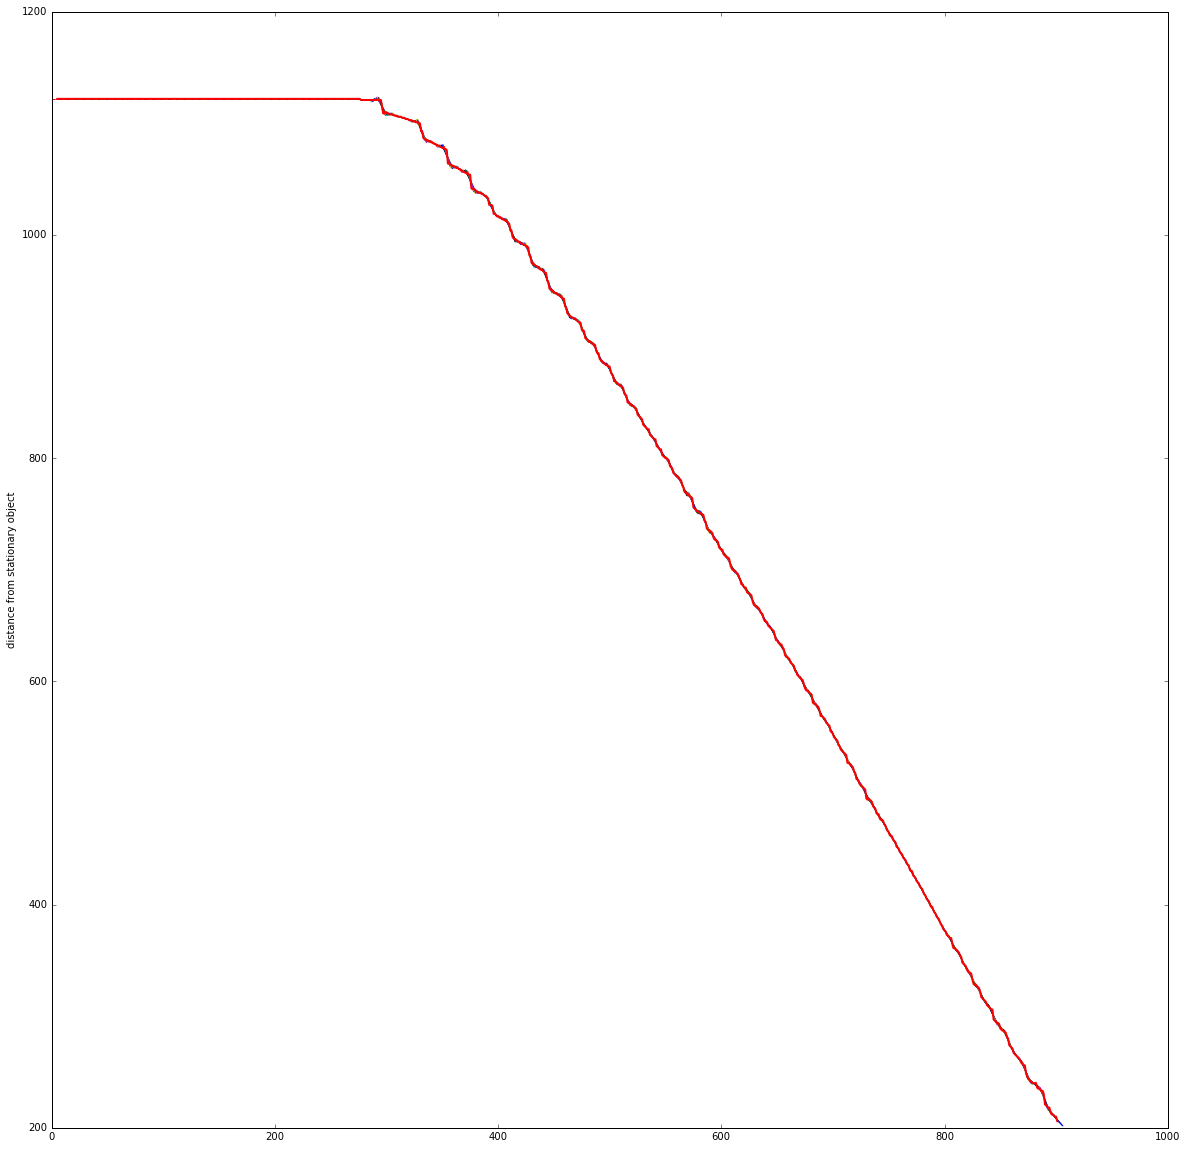

In [149]:
num_points = 11
polyfits = list()
for i in xrange(len(distances) - num_points):
    polyfit = np.polyfit(np.arange(num_points), distances[i:i + num_points], 2)
    polyfits.append(polyfit)
#         print first_derivative

x_start = 0
x_points = len(polyfits)
fig = plt.figure()
ax = fig.gca()
plt.ylabel("distance from stationary object")
# ax2 = ax1.twinx()
for i, coeff in enumerate(polyfits[x_start:x_start+x_points]):
    x = np.arange(x_start + i, x_start + i + num_points)
    y = map(lambda x: coeff[0]*x**2 + coeff[1]*x + coeff[2], np.arange(num_points))
#     y = map(lambda x: 2 * coeff[0] * x + coeff[1], x)
#     y = map(lambda x: coeff[0] * x, x)
#     y += distances[i+x_start+num_points]
    ax.plot(x, y, linewidth=1)
plt.plot(np.arange(x_start+5, x_start+5+x_points), 
         distances[x_start+5:x_start+5+x_points],
         linewidth=2, color="red")

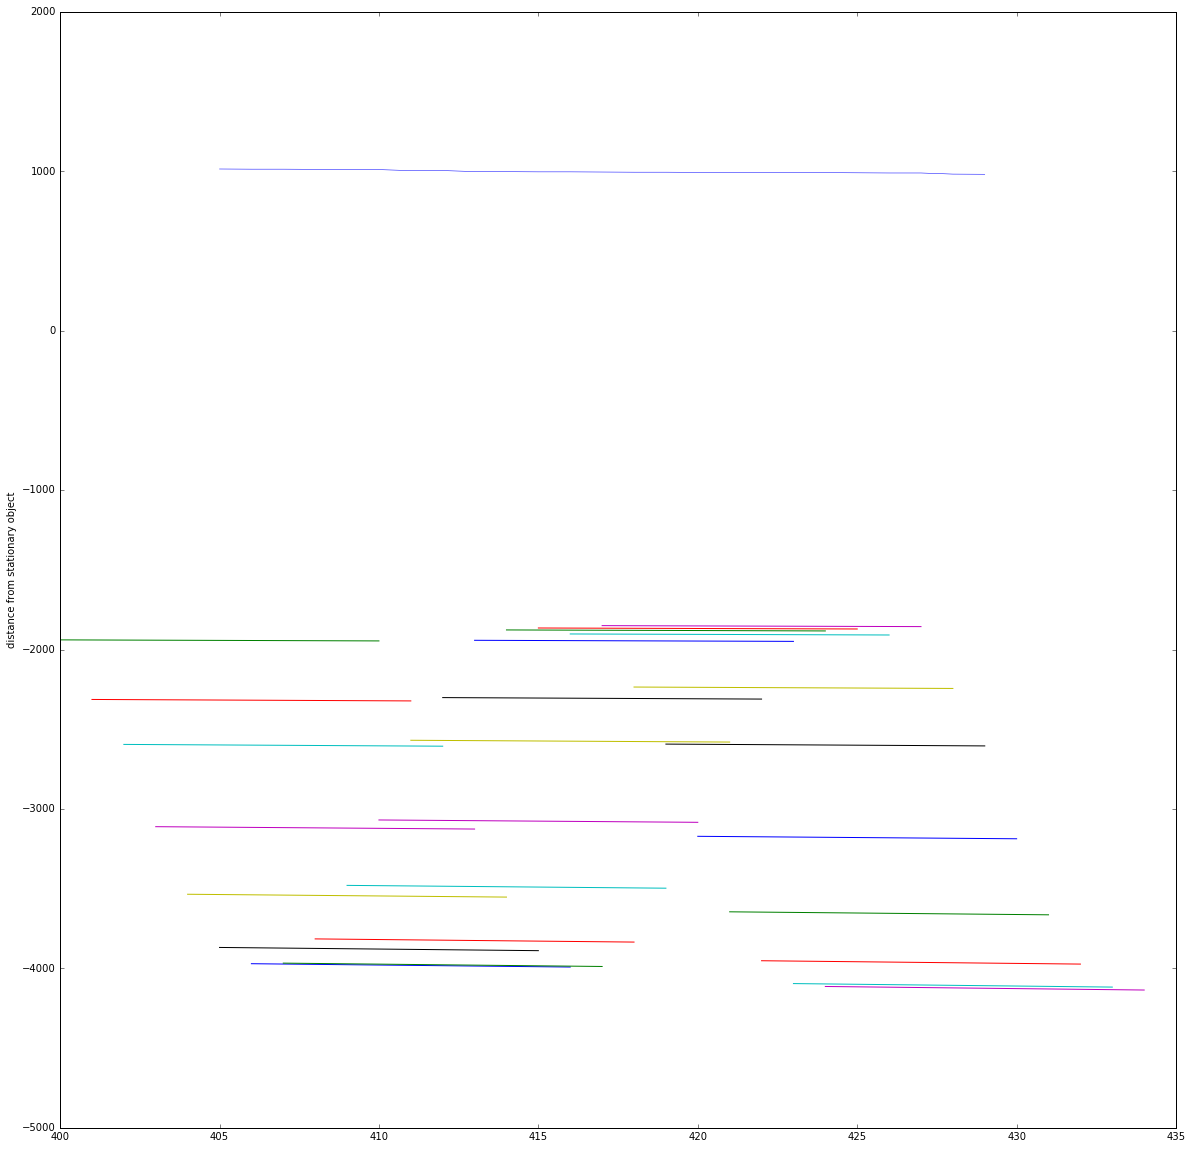

In [139]:
num_points = 11
polyfits = list()
for i in xrange(len(distances) - num_points):
    polyfit = np.polyfit(np.arange(num_points), distances[i:i + num_points], 2)
    polyfits.append(polyfit)
#         print first_derivative

x_start = 400
x_points = 25
plt.plot(np.arange(x_start+5, x_start+5+x_points), 
         distances[x_start+5:x_start+5+x_points],
         linewidth=0.5)
ax = plt.gca()
plt.ylabel("distance from stationary object")
# ax2 = ax1.twinx()
for i, coeff in enumerate(polyfits[x_start:x_start+x_points]):
    x_points = np.arange(x_start + i, x_start + i + num_points)
    slope = 2 * coeff[0] * 5 + coeff[1]
    y = map(lambda x: slope*x - (distances[x_points[4]]-distances[x_points[4]]*slope), x_points)
#     y = map(lambda x: 2 * coeff[0] * x + coeff[1], x)
#     y = map(lambda x: coeff[0] * x, x)
#     y += distances[i+x_start+num_points]
    ax.plot(x_points, y, linewidth=1)

In [51]:
x = np.random.random(10)
a1 = np.cumsum(np.insert(x, 0, 0))
print x
n = 3
print (a1[n:] - a1[:-n]) / n

[ 0.37912863  0.20574558  0.71823604  0.60422577  0.63327756  0.40278709
  0.18543961  0.14847965  0.00725997  0.14667485]
[ 0.43437008  0.50940246  0.65191312  0.54676347  0.40716809  0.24556878
  0.11372641  0.10080482]


In [47]:
a1[2:] - a1[:-2]

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17])